## Importowanie pakietów

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from collections import defaultdict

## Definicja sieci

In [146]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim, initial_sigma=1.0, sigma_decay=1.0, init_lr=0.1, decay_rate=100, neighborhood_function='gaussian'):
        # Inicjalizacja sieci z podanymi parametrami oraz przygotowanie wag i mapy klastrów.
        self.M, self.N, self.input_dim = M, N, input_dim
        self.initial_sigma, self.sigma_decay = initial_sigma, sigma_decay
        self.init_lr, self.decay_rate = init_lr, decay_rate
        self.weights = np.random.rand(M, N, input_dim)
        self.bmu_cluster_map = np.zeros((M, N), dtype=int)
        self.neighborhood_function = neighborhood_function

    def _neighborhood_function(self, distance, sigma):
        # Funkcja sąsiedztwa, która oblicza wpływ odległości na aktualizację wag.
        if self.neighborhood_function == 'gaussian':
            return np.exp(-distance**2 / (2 * sigma**2))
        elif self.neighborhood_function == 'mexican_hat':
            return (1 - (distance**2 / sigma**2)) * np.exp(-distance**2 / (2 * sigma**2))
        else:
            raise ValueError(f"Nieznana funkcja sąsiedztwa: {self.neighborhood_function}")

    def train(self, input_data, input_labels, num_epochs):
        # Proces uczenia sieci przez określoną liczbę epok.
        for epoch in range(num_epochs):
            sigma = self.initial_sigma * np.exp(-epoch / self.decay_rate) * self.sigma_decay
            learning_rate = self.init_lr * np.exp(-epoch / self.decay_rate)
            cluster_statistics = defaultdict(lambda: defaultdict(int))
            for data_sample, data_label in zip(input_data, input_labels):
                best_matching_unit = self._find_bmu_and_update_weights(data_sample, sigma, learning_rate)
                cluster_statistics[best_matching_unit][data_label] += 1
            for bmu, stats in cluster_statistics.items():
                self.bmu_cluster_map[bmu] = max(stats, key=stats.get)

    def _find_bmu_and_update_weights(self, sample, sigma, lr):
        # Znalezienie BMU, aktualizacja wag i zwrócenie BMU.
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu = np.unravel_index(np.argmin(distances), distances.shape)
        
        if sigma and lr:
            x, y = np.ogrid[0:self.M, 0:self.N]
            distance = np.sqrt((x - bmu[0])**2 + (y - bmu[1])**2)
            influence = self._neighborhood_function(distance, sigma)
            self.weights += lr * influence[..., np.newaxis] * (sample - self.weights)
        
        return bmu
        
    def accuracy(self, data, labels):
        correct = 0
        total = len(data)
        
        if total == 0:
            return 0

        for sample, label in zip(data, labels):
            bmu = self._find_bmu_and_update_weights(sample, None, None)
            if self.bmu_cluster_map[bmu] == label:
                correct += 1

        return 100 * correct / total
    
    def assign_clusters(self, input_data, input_labels):
        # Mapowanie klastrów na podstawie danych wejściowych i etykiet.
        cluster_stats = defaultdict(list)
        cluster_matrix = np.zeros((self.M, self.N))
        coverage_matrix = np.zeros((self.M, self.N))

        for data_sample, data_label in zip(input_data, input_labels):
            best_matching_unit = self._find_bmu_and_update_weights(data_sample, None, None)  # Aktualizacja wag nie jest potrzebna
            cluster_stats[best_matching_unit].append(data_label)

        # Aktualizacja macierzy klastra i pokrycia.
        for (i, j), label_list in cluster_stats.items():
            most_common_label = max(set(label_list), key=label_list.count)
            coverage_percentage = 100 * label_list.count(most_common_label) / len(label_list)
            cluster_matrix[i, j] = most_common_label
            coverage_matrix[i, j] = coverage_percentage
            print(f"BMU ({i}, {j}) przeważnie reprezentuje klaster {most_common_label} z pokryciem {coverage_percentage}%.")


    def display_clustered_data(self, input_data, neuron_positions=True):
        # Wizualizacja sklastrowanych danych wejściowych.
        assigned_clusters = np.array([self.bmu_cluster_map[self._find_bmu_and_update_weights(sample, None, None)] for sample in input_data])
        distinct_clusters = np.unique(assigned_clusters)
        color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d' if input_data.shape[1] == 3 else None)

        # Wyświetlanie danych wejściowych sklastrowanych
        for i, cluster in enumerate(distinct_clusters):
            cluster_mask = assigned_clusters == cluster
            if input_data.shape[1] == 3:
                ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], input_data[cluster_mask, 2], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {cluster}')
            else:
                ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {cluster}')
        if neuron_positions:
            # Dodanie pozycji neuronów
            neuron_positions = np.array([self.weights[i, j, :] for i in range(self.M) for j in range(self.N)])
            if input_data.shape[1] == 3:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], neuron_positions[:, 2], color='red', edgecolors='k', s=100, marker='o', label='Neurony')
            else:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='red', edgecolors='k', s=100, marker='o', label='Neurony')

        ax.set_title('3D Clustered Data' if input_data.shape[1] == 3 else '2D Clustered Data')
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        if input_data.shape[1] == 3:
            ax.set_zlabel('Dim 3')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

## Załadowanie i wizualizacja danych

In [147]:
hexagon = pd.read_csv('../data/hexagon.csv').values
cube = pd.read_csv('../data/cube.csv').values

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/3471852301.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_colors))


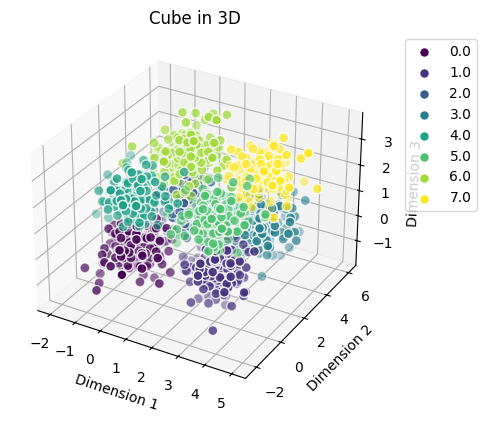

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_colors = np.unique(cube[:, 3])
colors = plt.cm.get_cmap('viridis', len(unique_colors))

for i, color in enumerate(unique_colors):
    mask = cube[:, 3] == color
    ax.scatter(cube[mask, 0], cube[mask, 1], cube[mask, 2], color=colors(i), edgecolors='w', s=50, label=f'{color}')

ax.set_title('Cube in 3D')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [149]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [150]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

## Unikalne klasy w danych

In [151]:
unique_labels = np.unique(labels_cube)
print(unique_labels)


[0. 1. 2. 3. 4. 5. 6. 7.]


## Testowanie sieci z gaussowską funkcją sąsiedztwa 

### Modyfikowanie parametrem sigma

In [152]:
network_a = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=1.0, sigma_decay=1, init_lr=0.1, decay_rate=1)

In [153]:
network_a.train(data_cube, labels_cube, 10)

In [99]:
accuracy = network_a.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 94.58333333333333%


In [100]:
network_a.assign_clusters(data_cube, labels_cube)

BMU (0, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 66.66666666666667%.
BMU (2, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 96.0%.
BMU (8, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (0, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (5, 0) przeważnie reprezentuje klaster 4.0 z pokryciem 80.0%.
BMU (0, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (5, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (1, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 83.33333333333333%.
BMU (7, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (4, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 9) przeważnie reprezentuje klaster 4.0 z pokryciem 66.66666666666667%.
BMU (3, 1) przeważnie reprezentuje klaster 4.0 z pokryciem 93.75%.
BMU (6, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 33.333333333333336%.
BMU (0, 1) prze

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


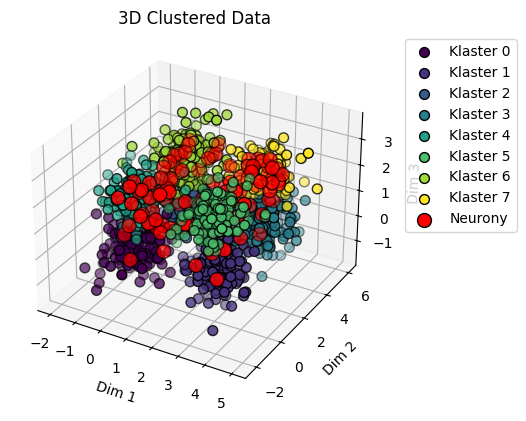

In [101]:
network_a.display_clustered_data(data_cube)

In [102]:
network_b = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.10, decay_rate=1)

In [103]:
network_b.train(data_cube, labels_cube, 10)

In [104]:
accuracy = network_b.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 93.41666666666667%


In [105]:
network_b.assign_clusters(data_cube, labels_cube)

BMU (7, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (4, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (1, 2) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (1, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 4) przeważnie reprezentuje klaster 4.0 z pokryciem 95.23809523809524%.
BMU (2, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (8, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (1, 1) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 81.81818181818181%.
BMU (1, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (8, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (5, 9) przeważnie reprezentuje kla

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


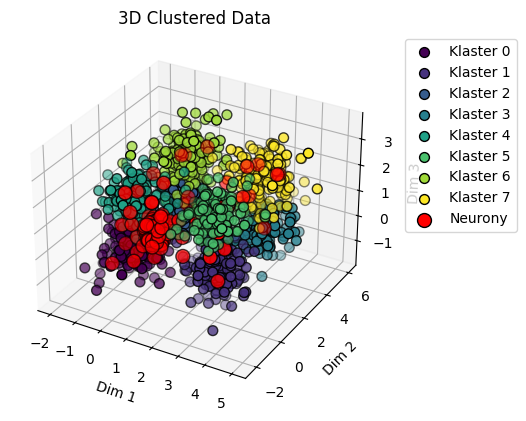

In [106]:
network_b.display_clustered_data(data_cube)

In [107]:
network_c = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.10, decay_rate=1)

In [108]:
network_c.train(data_cube, labels_cube, 10)

In [109]:
accuracy = network_c.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 71.83333333333333%


In [110]:
network_c.assign_clusters(data_cube, labels_cube)

BMU (1, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (0, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 1) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 7) przeważnie reprezentuje klaster 4.0 z pokryciem 94.87179487179488%.
BMU (5, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 5) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 2) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 76.47058823529412%.
BMU (8, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 66.66666666666667%.
BMU (2, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (4, 1) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 8) przeważnie repr

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


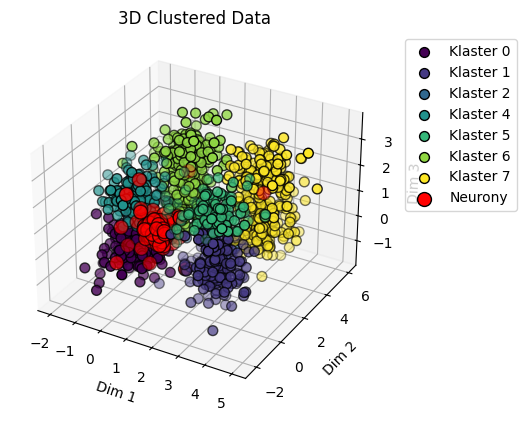

In [111]:
network_c.display_clustered_data(data_cube)

### Sprawdzenie dla małego iloczynu MxN

In [112]:
network2 = KohonenNetwork(M=3, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100)


In [113]:
network2.train(data_cube, labels_cube, 10)

In [114]:
accuracy2 = network2.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy2}%")

Cluster accuracy: 28.166666666666668%


In [115]:
network2.assign_clusters(data_cube, labels_cube)

BMU (1, 1) przeważnie reprezentuje klaster 4.0 z pokryciem 58.8%.
BMU (0, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 95.55555555555556%.
BMU (0, 1) przeważnie reprezentuje klaster 2.0 z pokryciem 16.574585635359117%.


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


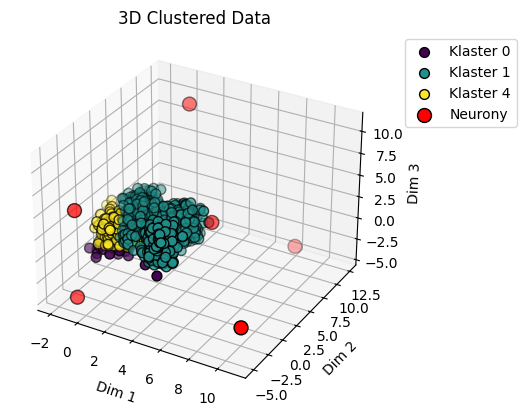

In [116]:
network2.display_clustered_data(data_cube)

## Testowanie sieci z funkcją sąsiedztwa minus druga pochodną funkcji gaussowskiej

### Modyfikowanie parametrem sigma

In [117]:
network_a = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=1.0, sigma_decay=1, init_lr=0.1, decay_rate=1, neighborhood_function='mexican_hat')

In [118]:
network_a.train(data_cube, labels_cube, 10)

In [119]:
accuracy = network_a.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 73.91666666666667%


In [120]:
network_a.assign_clusters(data_cube, labels_cube)

BMU (9, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 95.23809523809524%.
BMU (1, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 97.5%.
BMU (9, 4) przeważnie reprezentuje klaster 5.0 z pokryciem 50.0%.
BMU (9, 5) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (8, 8) przeważnie reprezentuje klaster 4.0 z pokryciem 92.6470588235294%.
BMU (6, 2) przeważnie reprezentuje klaster 1.0 z pokryciem 96.6887417218543%.
BMU (1, 4) przeważnie reprezentuje klaster 5.0 z pokryciem 99.24812030075188%.
BMU (4, 9) przeważnie reprezentuje klaster 2.0 z pokryciem 100.0%.
BMU (5, 1) przeważnie reprezentuje klaster 6.0 z pokryciem 52.65017667844523%.
BMU (1, 8) przeważnie reprezentuje klaster 7.0 z pokryciem 50.0%.
BMU (0, 0) przeważnie reprezentuje klaster 4.0 z pokryciem 100.0%.


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


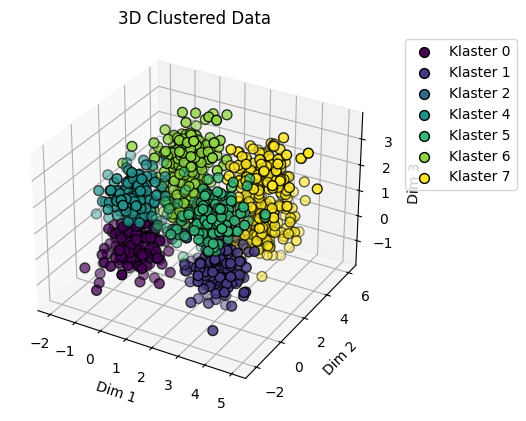

In [122]:
network_a.display_clustered_data(data_cube, neuron_positions=False)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


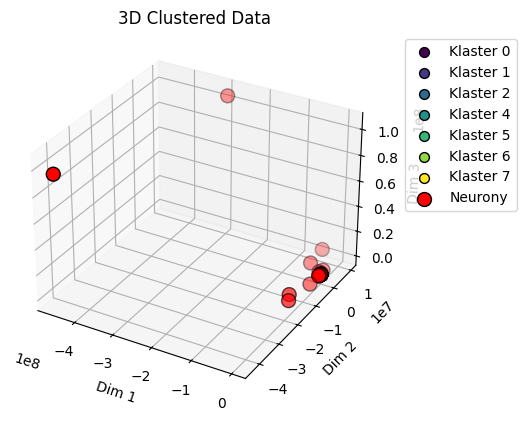

In [123]:
network_a.display_clustered_data(data_cube)

In [124]:
network_b = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.10, decay_rate=1, neighborhood_function='mexican_hat')

In [125]:
network_b.train(data_cube, labels_cube, 10)

In [126]:
accuracy = network_b.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 93.75%


In [127]:
network_b.assign_clusters(data_cube, labels_cube)

BMU (9, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 2) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (8, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (5, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (2, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (4, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 70.0%.
BMU (6, 7) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (7, 3) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 5) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 81.81818181818181%.
BMU (8, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 6) przeważnie reprezentuje klaster 0.0 z po

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


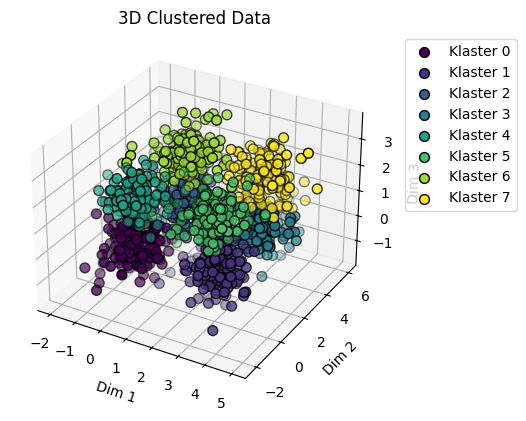

In [129]:
network_b.display_clustered_data(data_cube, neuron_positions=False)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


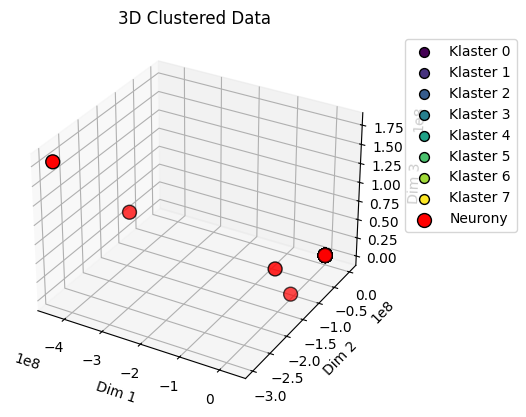

In [130]:
network_b.display_clustered_data(data_cube)

In [131]:
network_c = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.10, decay_rate=1, neighborhood_function='mexican_hat')

In [132]:
network_c.train(data_cube, labels_cube, 10)

In [133]:
accuracy = network_c.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy}%")

Cluster accuracy: 75.83333333333333%


In [134]:
network_c.assign_clusters(data_cube, labels_cube)

BMU (1, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (0, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 95.0%.
BMU (6, 2) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (2, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (0, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (4, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 6) przeważnie reprezentuje klaster 4.0 z pokryciem 56.25%.
BMU (6, 4) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 9) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (5, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (6, 1) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (1, 6) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (9, 8) przeważnie reprezentuje klaster 0.0 z pokryciem 68.42105263157895%.
BMU (6, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 100.0%.
BMU (3, 4) przeważnie reprezentuje klaster 0.0 z po

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/2855597863.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


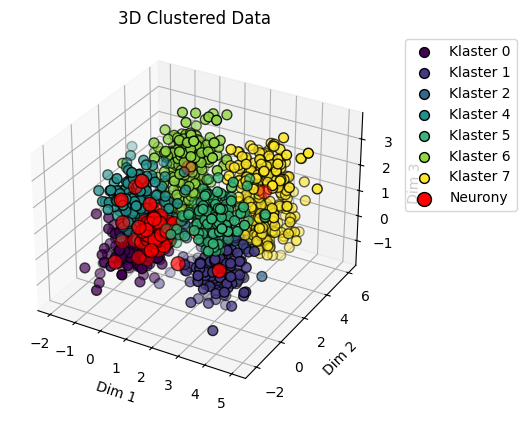

In [135]:
network_c.display_clustered_data(data_cube)

### Sprawdzenie dla małego iloczynu MxN

In [86]:
network2 = KohonenNetwork(M=3, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=1, neighborhood_function='mexican_hat')


In [87]:
network2.train(data_cube, labels_cube, 10)

In [88]:
accuracy2 = network2.accuracy(data_cube, labels_cube)
print(f"Cluster accuracy: {accuracy2}%")

Cluster accuracy: 25.0%


In [89]:
network2.assign_clusters(data_cube, labels_cube)

BMU (0, 0) przeważnie reprezentuje klaster 0.0 z pokryciem 25.0%.
BMU (0, 1) przeważnie reprezentuje klaster 2.0 z pokryciem 25.0%.


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_5600/1571843397.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


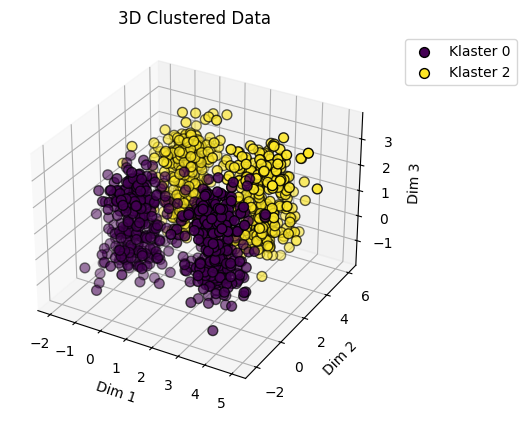

In [90]:
network2.display_clustered_data(data_cube)